# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIw

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [4]:
# # Setting features for further feature extraction by choosing columns
# # Some will be "simply" encoded via label encoding and others with HashingVectorizer

SIMPLE_HEADERS = [ 'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Mode',
    'request.headers.Sec-Fetch-Dest',
    'request.headers.Sec-Fetch-Site'
                ]
# On these headers we will run HashingVectorizer

COMPLEX_HEADERS = ['response.headers.Content-Type','request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'response.body',
                   'request.headers.Date',
                    'response.headers.Location',
                    'request.headers.Cookie',
                    ]


COLUMNS_TO_REMOVE = ['request.headers.Accept-Encoding',
                     
                     'response.status','response.status_code','response.headers.Set-Cookie',
                     'request.headers.Content-Length']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df
df['response.headers.Content-Length'] = pd.to_numeric(df['response.headers.Content-Length'])

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.headers.Content-Type,response.headers.Content-Length,response.body,request.headers.Cookie,response.headers.Location,attack_type,label
0,127.0.0.1:5000,-0.632456,*/*,keep-alive,1,0,0,?1,0,-0.786334,-0.57735,0,http://127.0.0.1:5000/static/download_txt/../....,,-1.0,72,0.000000,-1.000000,-1.0,Directory Traversal,Malware
1,127.0.0.1:5000,-0.632456,*/*,keep-alive,0,0,0,?1,0,-0.786146,-0.57735,0,http://127.0.0.1:5000/categories/check/name/2467,,-1.0,41,0.000000,-1.000000,-1.0,Benign,Benign
2,127.0.0.1:5000,-0.800000,*/*,keep-alive,0,0,0,?1,0,-0.751646,-0.57735,0,http://127.0.0.1:5000/cookielogin,,-1.0,105,0.436436,-0.408248,-1.0,Cookie Injection,Malware
3,127.0.0.1:5000,-0.516398,*/*,keep-alive,1,0,0,?1,0,-0.716002,-0.57735,0,http://127.0.0.1:5000/states/get/region/6117,,-1.0,30,0.577350,-1.000000,-1.0,Benign,Benign
4,127.0.0.1:5000,0.377964,*/*,keep-alive,0,0,0,?1,29,-0.691095,-0.57735,0,http://127.0.0.1:5000/categories/check/name/2508,,-1.0,41,0.000000,-1.000000,-1.0,LOG4J,Malware


# URL

In [5]:
from bs4 import BeautifulSoup
import urllib
import bs4
import re
import socket
import whois
from datetime import datetime
import time
# https://breakingcode.wordpress.com/2010/06/29/google-search-python/
# Previous package structure was modified. Import statements according to new structure added. Also code modified.
import googlesearch  as gs
# This import is needed only when you run this file in isolation.
import sys
from patterns import *
# Purpose - This file just stores all the regular expression patterns used in features_extraction.py so that there is
# a common source which can be used if any of the patterns are to be edited.

ipv4_pattern = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
ipv6_pattern = r"^(?:(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){6})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:::(?:(?:(?:[0-9a-fA-F]{1,4})):){5})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){4})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,1}(?:(?:[0-9a-fA-F]{1,4})))?::" \
               r"(?:(?:(?:[0-9a-fA-F]{1,4})):){3})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,2}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){2})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,3}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:[0-9a-fA-F]{1,4})):)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,4}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,5}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,6}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::))))$"
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
http_https = r"https://|http://"

In [6]:
# pip install whois

In [7]:
# pip install patterns

In [8]:
# pip install google-search

In [9]:
# !pip install google

In [10]:
def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 0 if match else 1


def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1


def url_length(url):
    if len(url) < 54:
        return 0
    else:
        return 1



def shortening_service(url):
    match = re.search(shortening_services, url)
    
    return 1 if match else 0


def having_at_symbol(url):
    match = re.search('@', url)
    return 1 if match else 0


def double_slash_redirecting(url):
    # since the position starts from 0, we have given 6 and not 7 which is according to the document.
    # It is convenient and easier to just use string search here to search the last occurrence instead of re.
    last_double_slash = url.rfind('//')
    return 1 if last_double_slash > 6 else 0


def prefix_suffix(domain):
    match = re.search('-', domain)
    return 1 if match else 0


def having_sub_domain(url):
    # Here, instead of greater than 1 we will take greater than 3 since the greater than 1 condition is when www and
    # country domain dots are skipped
    # Accordingly other dots will increase by 1
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 3:
        return 0
    else:
        return 1


def domain_registration_length(domain):
    expiration_date = domain.expiration_date
    today = time.strftime('%Y-%m-%d')
    today = datetime.strptime(today, '%Y-%m-%d')

    registration_length = 0
    # Some domains do not have expiration dates. This if condition makes sure that the expiration date is used only
    # when it is present.
    if expiration_date:
        registration_length = abs((expiration_date - today).days)
    return 1 if registration_length / 365 <= 1 else 0


def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 0 if match else 1



In [11]:
def check_url(url,domain,wiki):
    print(url)
#     if having_ip_address(url) == 1:
#         return 1
    if url_length(url)  == 1:
        print("url_length")
        return 1
    elif shortening_service(url) == 1:
        print("shortening_service")
        return 1
    elif having_at_symbol(url) == 1:
        print("having_at_symbol")
        return 1
    elif double_slash_redirecting(url)== 1:
        return 1


# lallal
    elif prefix_suffix(domain)== 1:
        print("prefix_suffix") 
        return 1
    elif having_sub_domain(url)== 1:
        print("having_sub_domain")
        return 1
# lallal
#     elif domain_registration_length(domain)== 1:
#         return 1
# # lallal
#     elif https_token(url)== 1:
#         return 1


    else:
        return 0

In [12]:
def get_hostname_from_url(url):
    
    hostname = url
    # TODO: Put this pattern in patterns.py as something like - get_hostname_pattern.
    pattern = "https://|http://|www.|https://www.|http://www."
    pre_pattern_match = re.search(pattern, hostname)

    if pre_pattern_match:
        hostname = hostname[pre_pattern_match.end():]
        post_pattern_match = re.search("/", hostname)
        if post_pattern_match:
            hostname = hostname[:post_pattern_match.start()]

    return hostname

In [13]:

# hostname=get_hostname_from_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt")
# domain = whois.query(hostname)
# print(check_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt",domain,hostname))

In [14]:
def change_url(df):  
    df_url=[]
    for index, row in df.iterrows():
        url=row["request.url"]
        hostname=get_hostname_from_url(url)
        domain=""
        try:
            domain = whois.query(hostname)
        except:
             dns = -1
        df_url.append(check_url(url,domain,hostname))

    # print(df.length())
    # print(df_url)
    # for index, row in df.iterrows():
    df["request.url"] =df_url
    return df


In [15]:

change_url(df)

http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt
url_length
http://127.0.0.1:5000/categories/check/name/2467
http://127.0.0.1:5000/cookielogin
http://127.0.0.1:5000/states/get/region/6117
http://127.0.0.1:5000/categories/check/name/2508
http://127.0.0.1:5000/login/user/4412
http://127.0.0.1:5000/login/admin/password/1980
http://127.0.0.1:5000/greet/%7B%7Bget_flashed_messages.__globals__.__builtins__.print('Running%20Payload!')%7D%7D
url_length
http://127.0.0.1:5000/orders/check/exists?val=9306%0ASUSPECTED:%20user%20Darin
url_length
http://127.0.0.1:5000/about/greet
http://127.0.0.1:5000/categories/check/name/4836
http://127.0.0.1:5000/categories/check/name/5391
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20categories%20limit33--
url_length
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20employees%20limit71--
url_length
http://127.0.0.1:5000/orders/check/exists?val=9624%0ACHECKPOINT:%20user%20Cedric
url_len

,request.headers.Host,request.headers.User-Agent,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.headers.Content-Type,response.headers.Content-Length,response.body,request.headers.Cookie,response.headers.Location,attack_type,label
0,127.0.0.1:5000,-0.632456,*/*,keep-alive,1,0,0,?1,0,-0.786334,-0.577350,0,1,,-1.0,72,0.000000,-1.000000,-1.0,Directory Traversal,Malware
1,127.0.0.1:5000,-0.632456,*/*,keep-alive,0,0,0,?1,0,-0.786146,-0.577350,0,0,,-1.0,41,0.000000,-1.000000,-1.0,Benign,Benign
2,127.0.0.1:5000,-0.800000,*/*,keep-alive,0,0,0,?1,0,-0.751646,-0.577350,0,0,,-1.0,105,0.436436,-0.408248,-1.0,Cookie Injection,Malware
3,127.0.0.1:5000,-0.516398,*/*,keep-alive,1,0,0,?1,0,-0.716002,-0.577350,0,0,,-1.0,30,0.577350,-1.000000,-1.0,Benign,Benign
4,127.0.0.1:5000,0.377964,*/*,keep-alive,0,0,0,?1,29,-0.691095,-0.577350,0,0,,-1.0,41,0.000000,-1.000000,-1.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,0.000000,*/*,keep-alive,2,0,1,?1,0,-0.750479,-0.316228,1,0,,-1.0,211,0.589768,0.000000,1.0,Cookie Injection,Malware
4278,127.0.0.1:5000,-0.755929,*/*,keep-alive,0,0,0,?1,0,-0.632456,-0.316228,0,0,,-1.0,36,0.000000,-1.000000,-1.0,Benign,Benign
4279,127.0.0.1:5000,0.000000,*/*,keep-alive,1,0,0,?1,0,-0.664411,-0.316228,1,0,,-1.0,211,0.589768,0.000000,1.0,Cookie Injection,Malware
4280,127.0.0.1:5000,-0.755929,*/*,keep-alive,1,0,0,?1,0,-0.514496,-0.235702,0,0,,-1.0,41,0.000000,-1.000000,-1.0,Benign,Benign


In [16]:
print (df["request.url"])

0       1
1       0
2       0
3       0
4       0
       ..
4277    0
4278    0
4279    0
4280    0
4281    0
Name: request.url, Length: 4282, dtype: int64


In [17]:
# removing columns with the same values
print("Before: " ,df.shape)
for col in df.columns:
    if len(df[col].unique()) == 1:
        # print("col drop: ",col)
        df = df.drop(col,axis=1)

print("After: " ,df.shape)

Before:  (4282, 21)
After:  (4282, 15)


In [18]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.User-Agent       4282 non-null   float64
 1   request.headers.Accept-Language  4282 non-null   int32  
 2   request.headers.Sec-Fetch-Site   4282 non-null   int32  
 3   request.headers.Sec-Fetch-Mode   4282 non-null   int32  
 4   request.headers.Sec-Fetch-Dest   4282 non-null   int32  
 5   request.headers.Set-Cookie       4282 non-null   float64
 6   request.headers.Date             4282 non-null   float64
 7   request.method                   4282 non-null   int32  
 8   request.url                      4282 non-null   int64  
 9   response.headers.Content-Length  4282 non-null   int64  
 10  response.body                    4282 non-null   float64
 11  request.headers.Cookie           4282 non-null   float64
 12  response.headers.Loc

In [19]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.headers.Date', 'request.method', 'request.url', 'response.headers.Content-Length', 'response.body', 'request.headers.Cookie', 'response.headers.Location']


request.headers.User-Agent         float64
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.headers.Date               float64
request.method                       int32
request.url                          int64
response.headers.Content-Length      int64
response.body                      float64
request.headers.Cookie             float64
response.headers.Location          float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [20]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3526, 13) (3526,)
(756, 13) (756,)


Counter({'Malware': 2264, 'Benign': 2018})

In [21]:
df

,request.headers.User-Agent,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.headers.Content-Length,response.body,request.headers.Cookie,response.headers.Location,attack_type,label
0,-0.632456,1,0,0,0,-0.786334,-0.577350,0,1,72,0.000000,-1.000000,-1.0,Directory Traversal,Malware
1,-0.632456,0,0,0,0,-0.786146,-0.577350,0,0,41,0.000000,-1.000000,-1.0,Benign,Benign
2,-0.800000,0,0,0,0,-0.751646,-0.577350,0,0,105,0.436436,-0.408248,-1.0,Cookie Injection,Malware
3,-0.516398,1,0,0,0,-0.716002,-0.577350,0,0,30,0.577350,-1.000000,-1.0,Benign,Benign
4,0.377964,0,0,0,29,-0.691095,-0.577350,0,0,41,0.000000,-1.000000,-1.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.000000,2,0,1,0,-0.750479,-0.316228,1,0,211,0.589768,0.000000,1.0,Cookie Injection,Malware
4278,-0.755929,0,0,0,0,-0.632456,-0.316228,0,0,36,0.000000,-1.000000,-1.0,Benign,Benign
4279,0.000000,1,0,0,0,-0.664411,-0.316228,1,0,211,0.589768,0.000000,1.0,Cookie Injection,Malware
4280,-0.755929,1,0,0,0,-0.514496,-0.235702,0,0,41,0.000000,-1.000000,-1.0,Benign,Benign


## Model choosing and fitting

In [22]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

## Result printout

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.91969   0.99719   0.95687       356
     Malware    0.99730   0.92250   0.95844       400

    accuracy                        0.95767       756
   macro avg    0.95849   0.95985   0.95766       756
weighted avg    0.96075   0.95767   0.95770       756



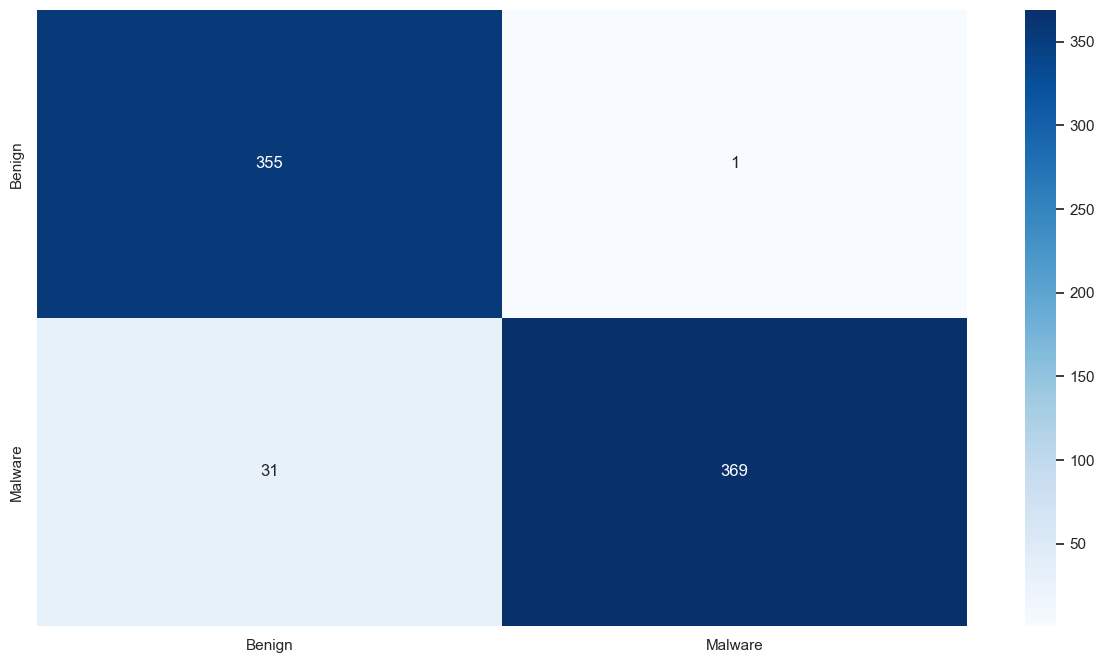

In [23]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=100)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))
ResultPrintout(clf)

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.91731   0.99719   0.95559       356
     Malware    0.99729   0.92000   0.95709       400

    accuracy                        0.95635       756
   macro avg    0.95730   0.95860   0.95634       756
weighted avg    0.95963   0.95635   0.95638       756



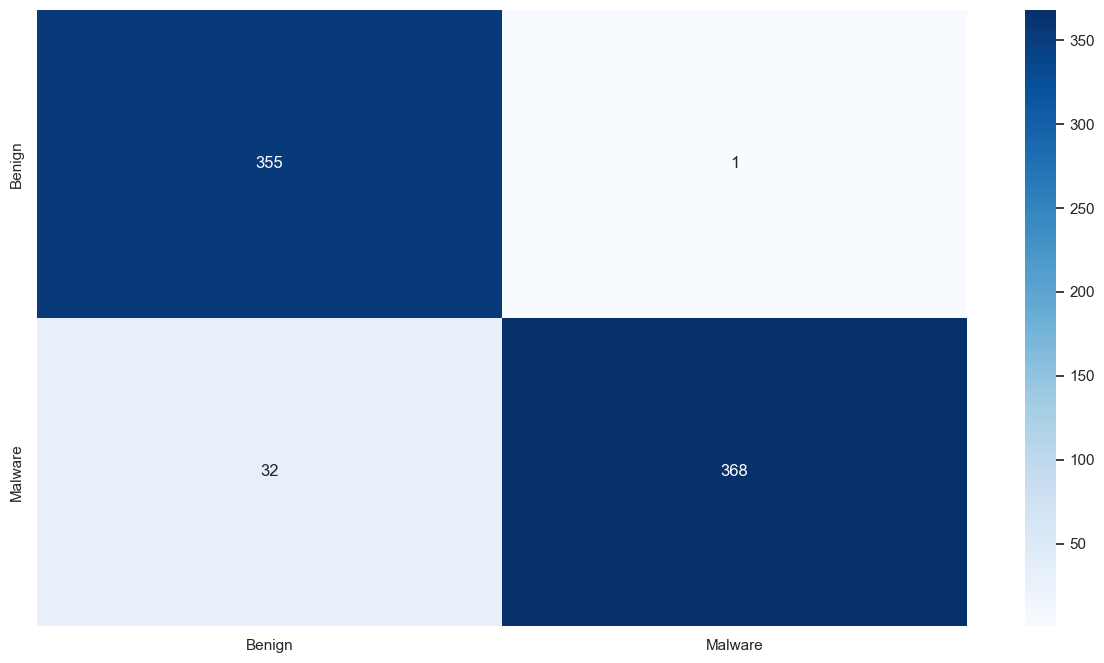

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# We choose our model of choice and set it's hyper parameters you can change anything
rfc = RandomForestClassifier()

parameters = {"n_estimators": [100,150,250,275,300,325,350,400]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
rfc = GridSearchCV(rfc, parameters)
# Train Model
rfc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
rfc = rfc.best_estimator_
ResultPrintout(rfc)

Feature: 0, Score: 0.03640
Feature: 1, Score: 0.01720
Feature: 2, Score: 0.01976
Feature: 3, Score: 0.00728
Feature: 4, Score: 0.03023
Feature: 5, Score: 0.06924
Feature: 6, Score: 0.03128
Feature: 7, Score: 0.02934
Feature: 8, Score: 0.37774
Feature: 9, Score: 0.16966
Feature: 10, Score: 0.06655
Feature: 11, Score: 0.12164
Feature: 12, Score: 0.02368


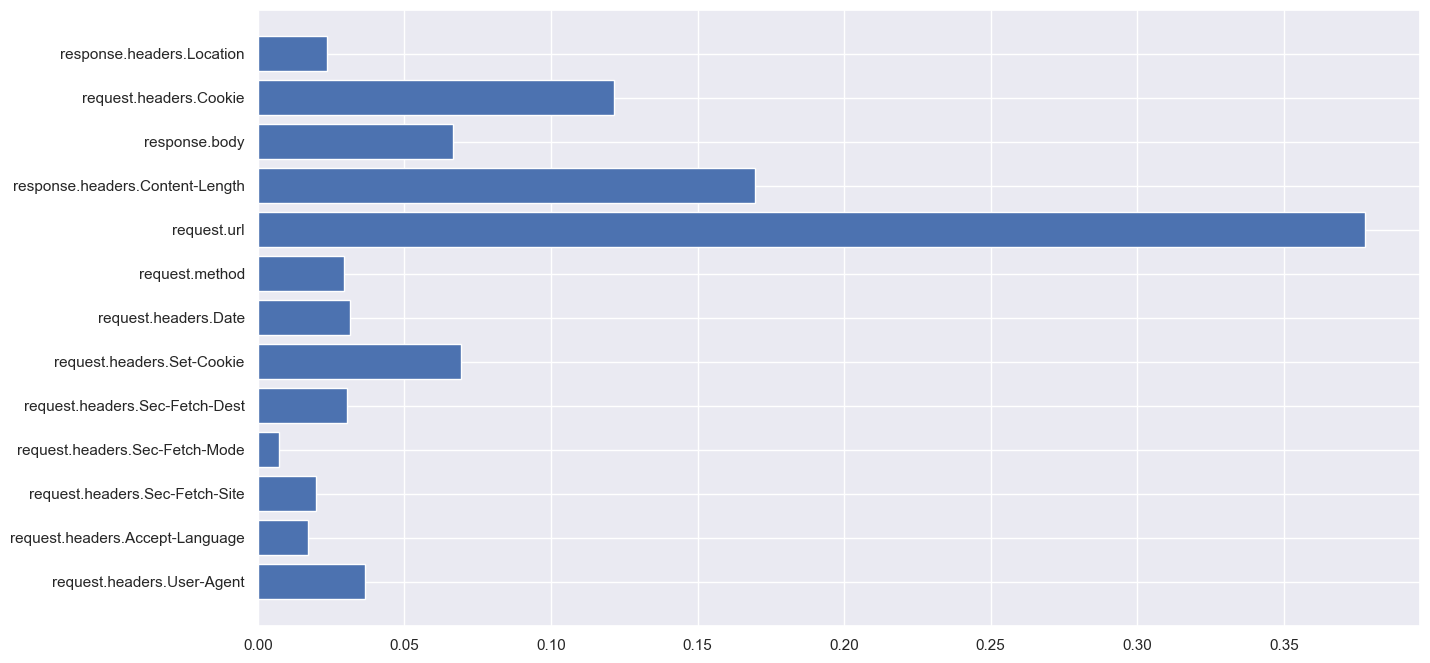

In [25]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

In [26]:
print(df['response.headers.Content-Length'])

0        72
1        41
2       105
3        30
4        41
       ... 
4277    211
4278     36
4279    211
4280     41
4281     41
Name: response.headers.Content-Length, Length: 4282, dtype: int64


C:\Users\97252\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.91623   0.98315   0.94851       356
     Malware    0.98396   0.92000   0.95090       400

    accuracy                        0.94974       756
   macro avg    0.95009   0.95157   0.94971       756
weighted avg    0.95206   0.94974   0.94978       756



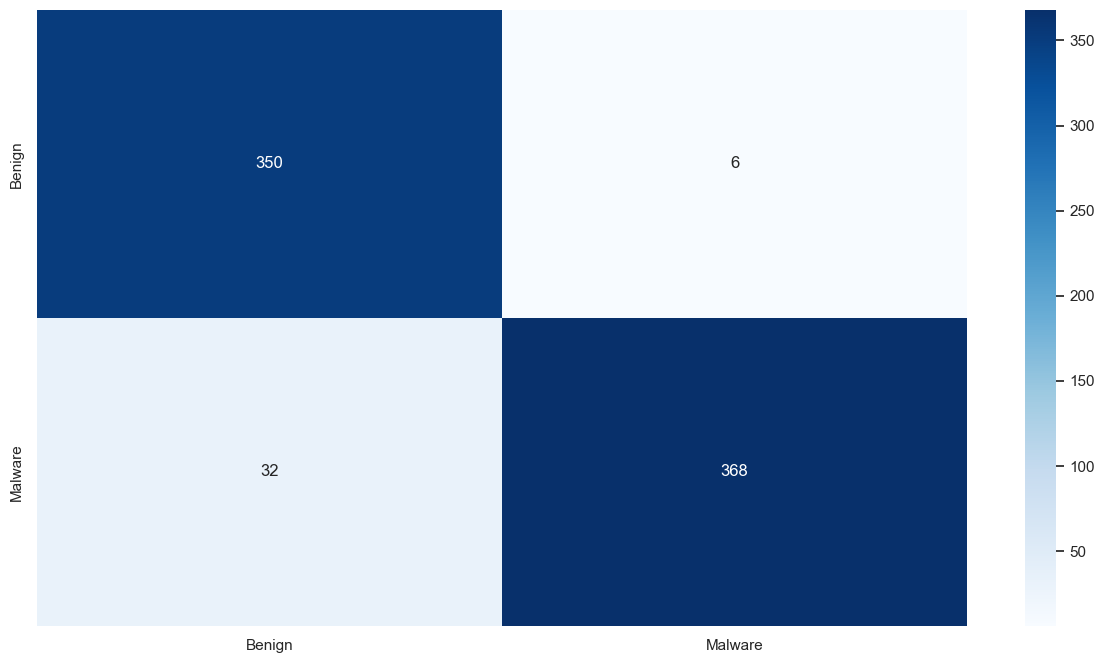

In [27]:
import xgboost as xgb
# We choose our model of choice and set it's hyper parameters you can change anything
xg = xgb.XGBClassifier(objective="binary:logistic", random_state=45)
xg.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))
ResultPrintout(xg)

Feature: 0, Score: 0.03640
Feature: 1, Score: 0.01720
Feature: 2, Score: 0.01976
Feature: 3, Score: 0.00728
Feature: 4, Score: 0.03023
Feature: 5, Score: 0.06924
Feature: 6, Score: 0.03128
Feature: 7, Score: 0.02934
Feature: 8, Score: 0.37774
Feature: 9, Score: 0.16966
Feature: 10, Score: 0.06655
Feature: 11, Score: 0.12164
Feature: 12, Score: 0.02368


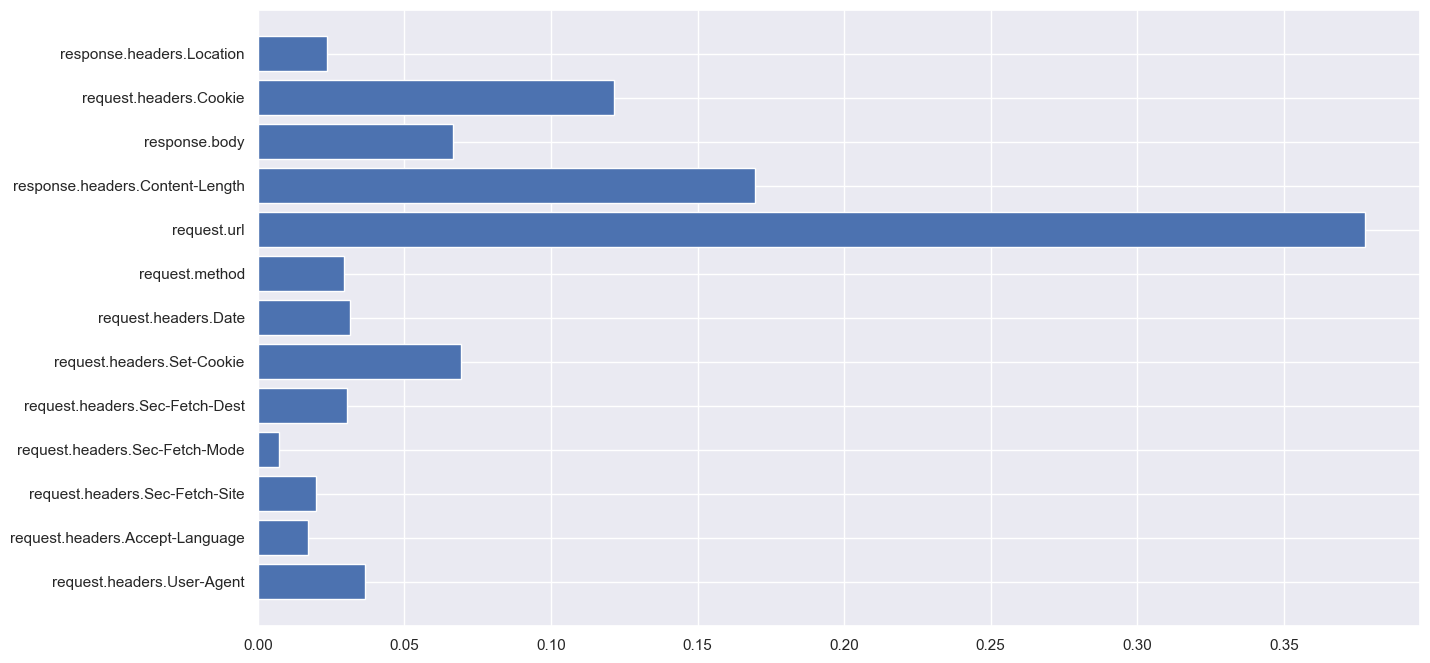

In [28]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
models={clf,rfc,xg}
for i in models:
    print(i)
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    print(accuracy_score(true_labels, predictions)*100)
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
#         print(best)
#         print(m)
        
print("-------")
print(best)
print(m)

RandomForestClassifier()
95.76719576719577
RandomForestClassifier()
95.63492063492063
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=45,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
94.97354497354497
-------
95.76719576719577
RandomForestClassifier()


# Test

In [30]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)
change_url(test_df)
# Predict with your model
X = test_df[features_list].to_numpy()
# for i in X.length():
#     if X[i] == 'none':
#         X[i] = 0
print(X)
predictions = m.predict(X)


http://127.0.0.1:5000/orders/check/exists/9701
http://127.0.0.1:5000/categories/check/number/5485
http://127.0.0.1:5000/states/6885
http://127.0.0.1:5000/states/10070
http://127.0.0.1:5000/about/greet
http://127.0.0.1:5000/cookielogin
http://127.0.0.1:5000/greet/%7B%7Bget_flashed_messages.__globals__.__builtins__.__import__('os').system%7D%7D
url_length
http://127.0.0.1:5000/login/admin/password/1358
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20us_states%20limit59--
url_length
http://127.0.0.1:5000/greet/3538
http://127.0.0.1:5000/orders/check/exists/9845
http://127.0.0.1:5000/states/get/region/2231
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/orders/get/random/9127
http://127.0.0.1:5000/orders/get/id/7794
http://127.0.0.1:5000/about/random_page
http://127.0.0.1:5000/login/user?username=Edward&password=PhilipJohnson'%20or%20'GeorgeMetz'='GeorgeMetz
url_length
http://127.0.0.1:5000/states/get/region/1722
http://127.0.0.1:5000/static/download

# Save your predictions

In [31]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')